In [1]:
from data import MultiMolGraphDataset
from torch_geometric.loader import DataLoader
import torch
import torchmetrics
from torchmetrics import MeanAbsoluteError

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
sdf_path = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data'
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data.csv'

# Read in target_data with pandas and then select 'psi_1_dihedral' column and convert the dihedral angles to sin and cos 
import pandas as pd
import numpy as np
# 1 & 2. Load your data
target_df = pd.read_csv(target_data)

# Drop -10 rows in the dihedral angle column
target_df = target_df[target_df['psi_1_dihedral'] != -10]

# 3. Extract the dihedral angles
angles = target_df['psi_1_dihedral']

# 3.1 Remove any -10 rows in the dihedral angle column
angles = angles[angles != -10]
# 3.2 Remove any NaN values
angles = angles.dropna()

# 4. If angles are in degrees, convert to radians
angles_rad = np.deg2rad(angles)

# 5. Compute sin & cos and assign
target_df['psi_1_dihedral_sin'] = np.sin(angles_rad)
target_df['psi_1_dihedral_cos'] = np.cos(angles_rad)

# Optional: inspect
print(target_df[['psi_1_dihedral', 'psi_1_dihedral_sin', 'psi_1_dihedral_cos']].head())



# 6. Save the modified DataFrame back to CSV
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/target_data_sin_cos.csv'
target_df.to_csv(target_data, index=False)

mol_dataset = MultiMolGraphDataset(
    root='.',
    sdf_folder=sdf_path,
    input_type=['r1h', 'r2h'],
    target_csv=target_data,
    target_columns=['psi_1_dihedral_sin', 'psi_1_dihedral_cos'],
    keep_hs=True,
    sanitize=False,
    force_reload=True
)

   psi_1_dihedral  psi_1_dihedral_sin  psi_1_dihedral_cos
0      313.550300           -0.724770            0.688991
2      292.580884           -0.923338            0.383987
3      233.012473           -0.798766           -0.601641
4       34.468778            0.565957            0.824435
5      202.755671           -0.386802           -0.922163
No target for 'rmg_rxn_1129' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1129.sdf
No target for 'rmg_rxn_1137' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1137.sdf
No target for 'rmg_rxn_1141' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1141.sdf
No target for 'rmg_rxn_1142' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1142.sdf
No target for 'rmg_rxn_1146' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_1146.sdf
No target for 'rmg_rxn_1147' in /home/calv

Processing...


No target for 'rmg_rxn_15401' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_15401.sdf
No target for 'rmg_rxn_15440' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_15440.sdf
No target for 'rmg_rxn_15595' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_15595.sdf
No target for 'rmg_rxn_16785' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_16785.sdf
No target for 'rmg_rxn_16786' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rmg_rxn_16786.sdf
No target for 'rxn_111' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rxn_111.sdf
No target for 'rxn_112' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rxn_112.sdf
No target for 'rxn_1125' in /home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/rxn_1125.sdf
No target for 'rxn_113' in /home/calvin/co

Done!


In [3]:
# Split the dataset into train and test sets and val sets [0.8, 0.1, 0.1]
train_size = int(0.8 * len(mol_dataset))
test_size = int(0.1 * len(mol_dataset))
val_size = len(mol_dataset) - train_size - test_size

import torch
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
    mol_dataset,
    [train_size, test_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_dataset,
    batch_size = 16,
    shuffle    = True,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)
test_loader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle    = False,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)
val_loader = DataLoader(
    val_dataset,
    batch_size = 32,
    shuffle    = False,
    follow_batch = ['x_s', 'x_t']    # tells PyG to create x_s_batch, x_t_batch
)

In [ ]:
from torch_geometric.data import Batch, Data

def extract_source_batch(pair_batch):
    # Use batch_s to split into individual graphs
    data_list = []
    batch_vec = pair_batch.batch_s  # Shape: [num_nodes]
    num_graphs = batch_vec.max().item() + 1

    for i in range(num_graphs):
        node_mask = (batch_vec == i)
        node_indices = node_mask.nonzero(as_tuple=False).view(-1)

        # Map old node indices to new ones
        node_id_map = {old.item(): new for new, old in enumerate(node_indices)}

        # Select edges where both nodes are in this subgraph
        src, dst = pair_batch.edge_index_s
        edge_mask = node_mask[src] & node_mask[dst]
        edge_indices = edge_mask.nonzero(as_tuple=False).view(-1)

        edge_index = pair_batch.edge_index_s[:, edge_indices]
        edge_attr = pair_batch.edge_attr_s[edge_indices]

        # Remap edge_index to new local node indices
        edge_index = edge_index.clone()
        edge_index[0] = edge_index[0].apply_(lambda x: node_id_map[x.item()])
        edge_index[1] = edge_index[1].apply_(lambda x: node_id_map[x.item()])

        data = Data(
            x=pair_batch.x_s[node_indices],
            edge_index=edge_index,
            edge_attr=edge_attr,
            batch=torch.zeros(len(node_indices), dtype=torch.long)
        )
        data_list.append(data)

    return Batch.from_data_list(data_list)


In [5]:
print(f"Number of training samples: {len(train_loader.dataset)}")

Number of training samples: 1356


In [6]:
import torch
import torch.nn.functional as F


def debug_nt_xent_loss(z1, z2, temperature=0.5):
    import torch.nn.functional as F

    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    N = z1.size(0)

    z = torch.cat([z1, z2], dim=0)  # shape: [2N, D]
    sim = torch.mm(z, z.T) / temperature  # shape: [2N, 2N]

    # remove self-similarity
    mask = torch.eye(2 * N, dtype=torch.bool, device=z.device)
    sim.masked_fill_(mask, -9e15)

    # target: each positive is the opposite view
    targets = torch.arange(N, device=z.device)
    targets = torch.cat([targets + N, targets])

    try:
        loss = F.cross_entropy(sim, targets)
    except Exception as e:
        print("Loss computation failed:", e)
        print("Sim shape:", sim.shape)
        print("Targets shape:", targets.shape)
        raise e

    return loss



In [7]:
from gine import GINEEncoder
encoder = GINEEncoder(
    node_in=133,
    edge_in=27,
    edge_proj=True,
    use_batchnorm=False,
    dropout=0.1,

)
encoder = encoder.to(device)

# projector = torch.nn.Sequential(
#     torch.nn.Linear(256, 512),
#     torch.nn.ReLU(),
#     torch.nn.Linear(512, 128)
# )
projector = torch.nn.Linear(256, 128)
projector = projector.to(device)

In [ ]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
def augment_graphs(data, drop_rate=0.05):
    num_nodes = data.num_nodes

    # Randomly drop nodes
    keep_mask = torch.rand(num_nodes, device=data.x.device) > drop_rate
    keep_indices = keep_mask.nonzero(as_tuple=False).view(-1)

    if keep_indices.numel() == 0:
        # Avoid creating an empty graph
        keep_indices = torch.tensor([0], device=data.x.device)

    edge_index, edge_attr = subgraph(
        keep_indices,
        data.edge_index,
        data.edge_attr,
        relabel_nodes=True,
        num_nodes=num_nodes
    )

    # Create new graph
    new_data = Data(
        x=data.x[keep_indices],
        edge_index=edge_index,
        edge_attr=edge_attr,
        batch=data.batch[keep_indices]
    )
    return new_data



In [9]:
batch = next(iter(train_loader))
print(batch)

PairDataBatch(y=[16, 2], id=[16], x_s=[145, 133], x_s_batch=[145], x_s_ptr=[17], edge_index_s=[2, 264], edge_attr_s=[264, 27], x_t=[144, 133], x_t_batch=[144], x_t_ptr=[17], edge_index_t=[2, 258], edge_attr_t=[258, 27], num_nodes_s=[16], num_nodes_t=[16], num_nodes=289, batch=[289], ptr=[17])


In [10]:
batch = next(iter(train_loader))


In [11]:
batch = next(iter(train_loader))
print(batch.num_graphs)  # Should be > 1

batch = extract_source_batch(batch).to(device)
print(batch)

16
DataBatch(x=[162, 133], edge_index=[2, 296], edge_attr=[296, 27], batch=[162], ptr=[17])


In [12]:
encoder

GINEEncoder(
  (edge_proj): Linear(in_features=27, out_features=256, bias=False)
  (input_proj): Linear(in_features=133, out_features=256, bias=True)
  (convs): ModuleList(
    (0-4): 5 x GINEConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    ))
  )
  (bns): ModuleList()
  (dropout_gnn): Dropout(p=0.1, inplace=False)
  (readout): Linear(in_features=256, out_features=256, bias=True)
  (head): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
)

In [19]:
print("Batch size:", batch.num_graphs)
print("view1.x == view2.x?", torch.allclose(view1.x, view2.x, atol=1e-4))
print("z1 shape:", z1.shape)
print("z1 std:", z1.std().item(), "z2 std:", z2.std().item())
print("Cosine sim avg:", F.cosine_similarity(z1, z2).mean().item())

Batch size: 16
view1.x == view2.x? False


NameError: name 'z1' is not defined

In [20]:
print("view1.x.shape:", view1.x.shape)
print("view1.batch:", view1.batch.shape)
print("view1.edge_index.shape:", view1.edge_index.shape)

print("view2.x.shape:", view2.x.shape)
print("view2.batch:", view2.batch.shape)
print("view2.edge_index.shape:", view2.edge_index.shape)

view1.x.shape: torch.Size([162, 133])
view1.batch: torch.Size([162])
view1.edge_index.shape: torch.Size([2, 282])
view2.x.shape: torch.Size([162, 133])
view2.batch: torch.Size([162])
view2.edge_index.shape: torch.Size([2, 281])


In [21]:
h1 = encoder(view1)
print("encoder(view1) shape:", h1.shape)

z1 = projector(h1)
print("projector(encoder(view1)) shape:", z1.shape)



: 

In [16]:
h2 = encoder(view2)
print("encoder(view2) shape:", h2.shape)
z2 = projector(h2)
print("projector(encoder(view2)) shape:", z2.shape)
print("z1 shape:", z1.shape)
print("z2 shape:", z2.shape)


NameError: name 'view2' is not defined

In [17]:
assert view1.batch is not None
print("Num graphs:", view1.batch.max().item() + 1)
print("Encoder output shape:", encoder(view1).shape)


NameError: name 'view1' is not defined

In [18]:
view1 = augment_graphs(batch, drop_rate=0.05)
view2 = augment_graphs(batch , drop_rate=0.05)

In [ ]:
z1 = projector(encoder(view1))
z2 = projector(encoder(view2))

In [ ]:
batch = next(iter(train_loader))
print(batch.num_graphs)  # Should be > 1

batch = extract_source_batch(batch).to(device)
print(batch)

view1 = augment_graphs(batch, drop_rate=0.05)
view2 = augment_graphs(batch , drop_rate=0.05)



print("z1 shape:", z1.shape)
print("z2 shape:", z2.shape)

loss = nt_xent_loss(z1, z2)
print("Loss:", loss.item())


16
DataBatch(x=[156, 133], edge_index=[2, 282], edge_attr=[282, 27], batch=[156], ptr=[17])
z1 shape: torch.Size([10, 128])
z2 shape: torch.Size([10, 128])
Loss: 2.937209367752075


In [ ]:
batch.x.shape

torch.Size([160, 133])

In [ ]:
print("z1 std:", z1.std().item())
print("z2 std:", z2.std().item())


z1 std: 0.7215703129768372
z2 std: 0.7327768802642822


In [ ]:
for batch in train_loader:
    print(batch.x_s.shape)
    break

torch.Size([172, 133])


In [ ]:
with torch.no_grad():
    h1 = encoder(view1.to(device))
    h2 = encoder(view2.to(device))
    print("Encoder h1 shape:", h1.shape)
    print("h1 mean:", h1.mean().item(), "std:", h1.std().item())
    print("h1 == h2?", torch.allclose(h1, h2, atol=1e-5))


Encoder h1 shape: torch.Size([1, 256])
h1 mean: -0.04500587657094002 std: 1.2969930171966553
h1 == h2? False


In [ ]:
from torch_geometric.nn import global_mean_pool
def forward_pass(view):
    return projector(encoder(view))

In [ ]:
import torch
import torch.nn.functional as F

def nt_xent_loss(z1, z2, temperature=0.5):
    """
    Compute the NT-Xent (contrastive) loss between two batches of embeddings.

    Args:
        z1: Tensor of shape [batch_size, dim] — embeddings from view 1
        z2: Tensor of shape [batch_size, dim] — embeddings from view 2
        temperature: scaling factor for logits

    Returns:
        Scalar contrastive loss
    """
    # Normalize the embeddings
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    # Concatenate along batch dimension: shape [2N, D]
    z = torch.cat([z1, z2], dim=0)

    # Cosine similarity matrix [2N, 2N]
    sim = torch.matmul(z, z.T) / temperature

    # Mask to remove similarity with self
    batch_size = z1.size(0)
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
    sim.masked_fill_(mask, float('-inf'))  # Ignore self-similarity

    # Positive pairs: i-th in z1 and (i + batch_size)-th in z2, and vice versa
    pos = torch.cat([
        torch.arange(batch_size, device=z.device) + batch_size,
        torch.arange(batch_size, device=z.device)
    ])

    # Labels point to positive index for each anchor
    labels = pos

    # Cross entropy loss
    loss = F.cross_entropy(sim, labels)

    return loss


In [ ]:
z1 = forward_pass(view1)
z2 = forward_pass(view2)

loss = nt_xent_loss(z1, z2)
print("Loss:", loss.item())


NameError: name 'forward_pass' is not defined

In [ ]:
sim = F.cosine_similarity(z1, z2)
print("Cosine sim avg:", sim.mean().item())
print("Min sim:", sim.min().item(), "Max sim:", sim.max().item())


Cosine sim avg: 0.9702394604682922
Min sim: 0.9488205909729004 Max sim: 0.9863104224205017


In [ ]:
print("view1.x[:5]", view1.x[:5])
print("view2.x[:5]", view2.x[:5])
print("x diff mean abs:", (view1.x - view2.x).abs().mean().item())


view1.x[:5] tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000,

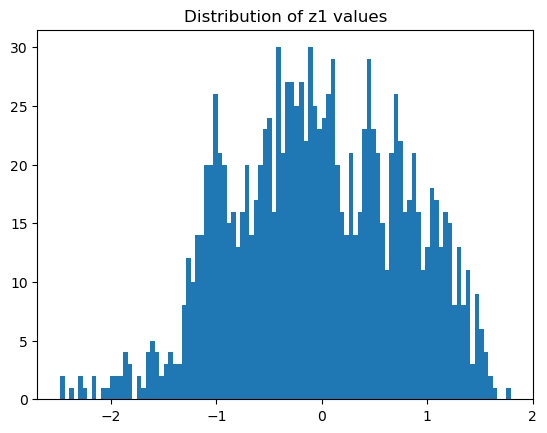

In [ ]:
import matplotlib.pyplot as plt
plt.hist(z1.detach().cpu().flatten().numpy(), bins=100)
plt.title("Distribution of z1 values")
plt.show()


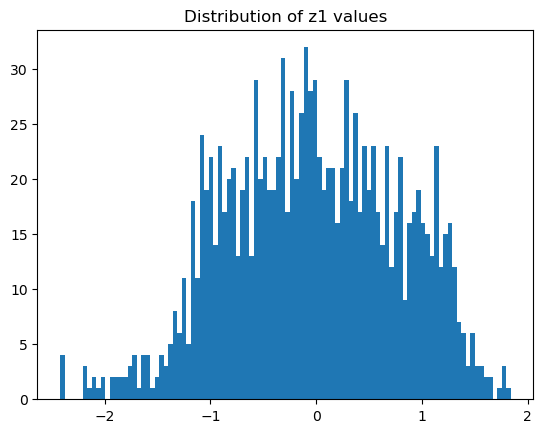

In [ ]:
import matplotlib.pyplot as plt
plt.hist(z2.detach().cpu().flatten().numpy(), bins=100)
plt.title("Distribution of z1 values")
plt.show()


In [ ]:
num_epochs = 10

In [ ]:
import torch
import torch.optim as optim

# Define optimizer and scheduler
optimizer = optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Outside the loop, accumulate
all_z1, all_z2 = [], []
all_view1, all_view2 = [], []

# Main training loop
encoder.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        batch = extract_source_batch(batch).to(device)
        # print(f"x shape: {batch.x.shape}, batch shape: {batch.batch.shape}, edge_index shape: {batch.edge_index.shape}")
        # Augmented views
        view1 = augment_graphs(batch)
        view2 = augment_graphs(batch)

        print("view1", view1)
        print("view2", view2)


        # Forward pass through encoder
        z1 = projector(encoder(view1))
        z2 = projector(encoder(view2))


        # Contrastive loss
        loss = nt_xent_loss(z1, z2)
        print("Loss:", loss.item())

        # Backprop
        optimizer.zero_grad()
        with torch.autograd.set_detect_anomaly(True):
            loss.backward()
        optimizer.step()

        # print("z1 std:", z1.std().item(), "z2 std:", z2.std().item())
        # print("Loss:", loss.item())
        # print("Grad norm:", sum(p.grad.norm().item() for p in encoder.parameters() if p.grad is not None))


        # Scheduler update — ONLY ONCE per epoch for WarmRestarts
        total_loss += loss.item()

    scheduler.step(epoch)  # Important: step with epoch, not batch!
    print(f"Epoch {epoch} | Loss: {total_loss / len(train_loader):.4f}")

    # Evaluate on validation set
    encoder.eval()
    t_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = extract_source_batch(batch).to(device)
            view1 = augment_graphs(batch)
            view2 = augment_graphs(batch)

            view1 = view1.to(device)
            view2 = view2.to(device)

            z1 = encoder(view1)
            z2 = encoder(view2)

            loss = nt_xent_loss(z1, z2)
            t_val_loss += loss.item()
    val_loss = t_val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")


with torch.no_grad():
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Normalize embeddings
    z1_norm = F.normalize(z1, dim=1)
    z2_norm = F.normalize(z2, dim=1)
    z = torch.cat([z1_norm, z2_norm], dim=0)  # shape: [2N, D]

    sim_matrix = z @ z.T  # Cosine similarity matrix [2N x 2N]

    # Plot heatmap (Optional: detach and move to CPU)
    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix.cpu().numpy(), cmap='viridis', xticklabels=False, yticklabels=False)
    plt.title("Cosine Similarity Matrix")
    plt.show()

: 

In [ ]:
def plot_tsne(z_list, title):
    import torch
    import torch.nn.functional as F
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import seaborn as sns

    # If input is a list, convert to a single tensor
    if isinstance(z_list, list):
        z = torch.cat(z_list, dim=0)
    else:
        z = z_list

    # Normalize
    z = F.normalize(z, dim=1)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, z.size(0) - 1))
    z_2d = tsne.fit_transform(z.cpu().numpy())

    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1])
    plt.title(title)
    plt.show()

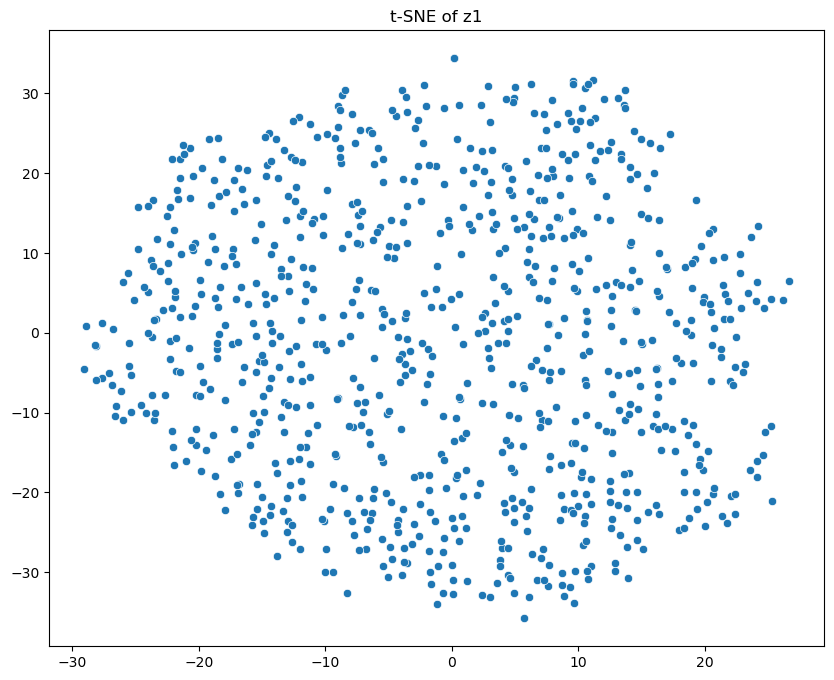

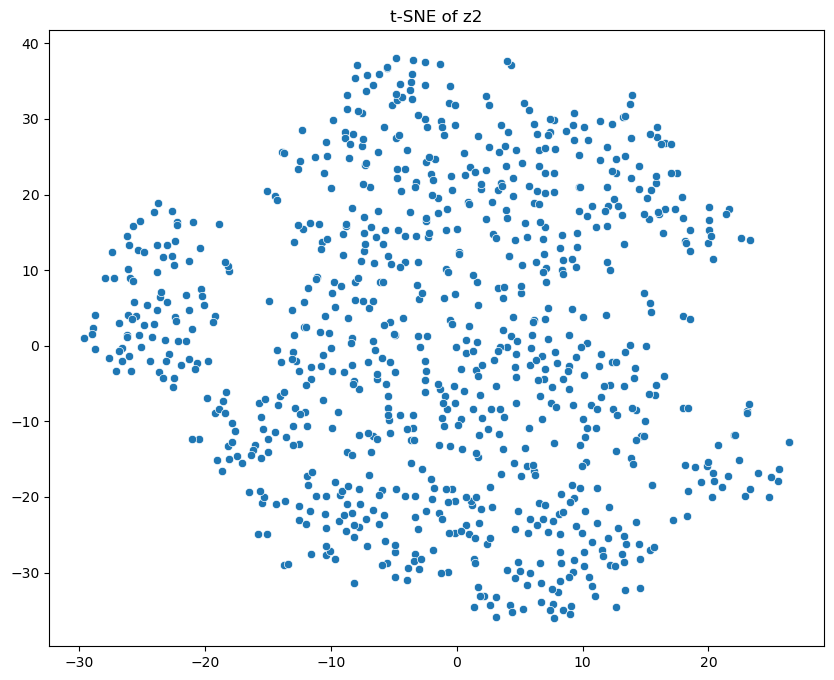

In [ ]:
plot_tsne(all_z1, "t-SNE of z1")
plot_tsne(all_z2, "t-SNE of z2")

In [ ]:
all_view1

[tensor([[1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0101],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.1201],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.1201],
         ...,
         [1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0101],
         [1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0101],
         [1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0101]]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.1201],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.1201],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.1201],
         ...,
         [1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0101],
         [1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0101],
         [1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0101]]),
 tensor([[1.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0101],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.1201],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.

In [ ]:
plot_tsne(all_view1, "t-SNE of view1")


KeyboardInterrupt: 

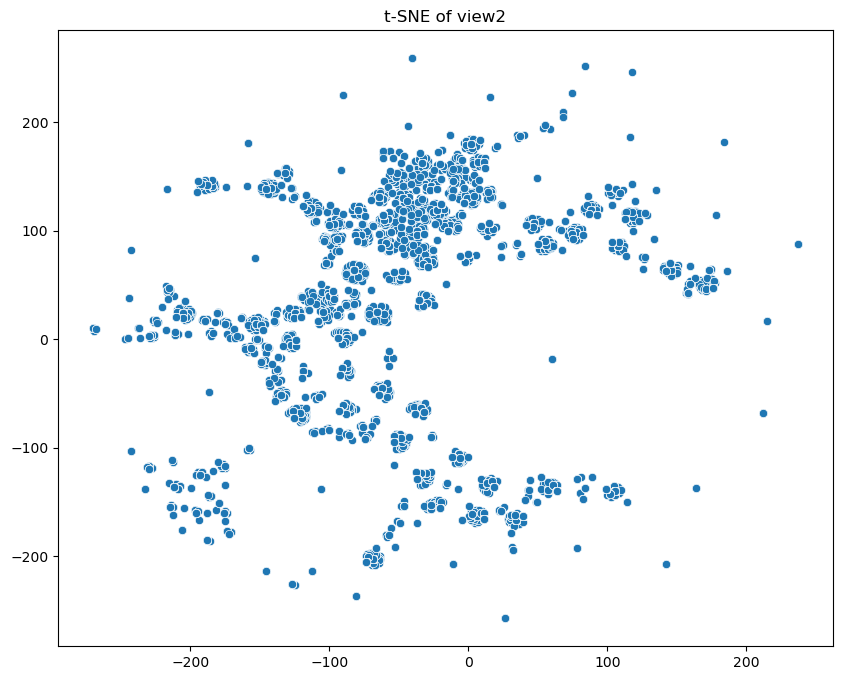

In [ ]:
plot_tsne(all_view2, "t-SNE of view2")

In [ ]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

def plot_augmented_views(v1, v2):
    g1 = to_networkx(v1)
    g2 = to_networkx(v2)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    nx.draw(g1, with_labels=True)
    plt.title("View 1")

    plt.subplot(1, 2, 2)
    nx.draw(g2, with_labels=True)
    plt.title("View 2")

    plt.show()
